In [2]:
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.sql.functions import *

from sklearn.preprocessing import MinMaxScaler
import pandas as pd

import nltk
from stop_words import get_stop_words
from nltk.corpus import stopwords
from wordcloud import WordCloud
from collections import ChainMap

import matplotlib.pyplot as plt

In [3]:
# Reading the datasets
prices = sqlContext.read.csv("/home/akshatp/Project/datasets/BTC_USD.csv", header=True)
tweets2021 = sqlContext.read.csv("/home/akshatp/Project/datasets/Bitcoin_tweets.csv", header=True)
tweets2016 = sqlContext.read.csv("/home/akshatp/Project/datasets/tweets2016.csv", header=True)
reddit = sqlContext.read.csv("/home/akshatp/Project/datasets/bitcoin_reddit_all.csv", header=True)

In [4]:
# Printing schema of datasets
prices.printSchema()
tweets2021.printSchema()
tweets2016.printSchema()
reddit.printSchema()

root
 |-- Date: string (nullable = true)
 |-- Open: string (nullable = true)
 |-- High: string (nullable = true)
 |-- Low: string (nullable = true)
 |-- Close: string (nullable = true)
 |-- Adj Close: string (nullable = true)
 |-- Volume: string (nullable = true)

root
 |-- user_name: string (nullable = true)
 |-- user_location: string (nullable = true)
 |-- user_description: string (nullable = true)
 |-- user_created: string (nullable = true)
 |-- user_followers: string (nullable = true)
 |-- user_friends: string (nullable = true)
 |-- user_favourites: string (nullable = true)
 |-- user_verified: string (nullable = true)
 |-- date: string (nullable = true)
 |-- text: string (nullable = true)
 |-- hashtags: string (nullable = true)
 |-- source: string (nullable = true)
 |-- is_retweet: string (nullable = true)

root
 |-- _c0: string (nullable = true)
 |-- id: string (nullable = true)
 |-- user: string (nullable = true)
 |-- fullname: string (nullable = true)
 |-- url: string (nullable 

In [5]:
# Changing datatypes in prices
prices = prices \
    .withColumn('Date', col('Date').cast(DateType())) \
    .withColumn('High', col('High').cast(DoubleType())) \
    .withColumn('Low', col('Low').cast(DoubleType())) \
    .withColumn('Open', col('Open').cast(DoubleType())) \
    .withColumn('Close', col('Close').cast(DoubleType()))\
    .withColumn('Volume', col('Volume').cast(DoubleType()))\
    .withColumn('Adj Close', col('Adj Close').cast(DoubleType()))

# Creating table
prices.registerTempTable("prices")

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [6]:
# Changing datatypes in tweets
tweets2021 = tweets2021 \
    .withColumn('date', col('date').cast(DateType())) \
    .withColumn('user_followers', col('user_followers').cast(IntegerType())) \
    .withColumn('user_friends', col('user_friends').cast(IntegerType())) \
    .withColumn('user_favourites', col('user_favourites').cast(IntegerType())) \
    .withColumn('user_verified', col('user_verified').cast(BooleanType()))\
    .withColumn('is_retweet', col('is_retweet').cast(BooleanType()))

# Cleaning the text
tweets2021 = tweets2021.withColumn("clean_text", lower(col("text")))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", "@",""))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", "#",""))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", "#[A-Za-z0-9_]+",""))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", r"http\S+", ""))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", r"www.\S+", ""))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", '[()!?]', ' '))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", '\[.*?\]',' '))
tweets2021 = tweets2021.withColumn("clean_text", f.regexp_replace("clean_text", "[^a-z0-9]"," "))

# Creating table
tweets2021.registerTempTable("tweets2021")

In [7]:
# Changing datatypes in prices
tweets2016 = tweets2016 \
    .withColumn('date', col('timestamp').cast(DateType())) \
    .withColumn('replies', col('replies').cast(IntegerType())) \
    .withColumn('likes', col('likes').cast(IntegerType())) \
    .withColumn('retweets', col('retweets').cast(IntegerType()))
# Creating table
tweets2016.registerTempTable("tweets2016")

In [8]:
# Changing datatypes in reddit
reddit = reddit \
    .withColumn('date', col('date').cast(DateType())) \
    .withColumn('score', col('score').cast(IntegerType())) \
    .withColumn('controversiality', col('controversiality').cast(IntegerType()))


# Creating table
reddit.registerTempTable("reddit")

## Computational Task 1
### How do fluctuations in the prices of Bitcoin affect the volume of tweets and comments across different platforms?

In [9]:
q1_final = sqlContext.sql("SELECT a.date as Date, a.rcomment_count, a.tweet_count, b.price as prices FROM \
     (SELECT a.date as Date, b.rcomment_count, a.tweet_count FROM \
     (SELECT date, COUNT(id) as tweet_count FROM tweets2016 GROUP BY date HAVING (date IS NOT NULL AND \
     (date BETWEEN '2016-01-01' AND '2019-12-31')) ) a JOIN \
     (SELECT date, COUNT(body) as rcomment_count FROM reddit WHERE date IS NOT NULL AND \
     (date BETWEEN '2016-01-01' AND '2019-12-31') GROUP BY date) b \
     ON a.date = b.date ORDER BY tweet_count DESC) a \
     JOIN (SELECT Date, Close as price FROM prices WHERE Date IS NOT NULL AND \
     (Date BETWEEN '2016-01-01' AND '2019-12-31') ORDER BY Date) b \
    ON a.date = b.date ORDER BY date")
q1_final.registerTempTable("q1_final")

In [10]:
# Converting Spark DataFrame to Pandas Dataframe
q1_finalpd = q1_final.toPandas()

In [11]:
# Using MinMax Scaler to Standardize the count values between 0 and 1
scaler = MinMaxScaler()

q1_scaled = q1_finalpd.copy()
q1_scaled[['rcomment_count']] = scaler.fit_transform(q1_finalpd[['rcomment_count']])
q1_scaled[['tweet_count']] = scaler.fit_transform(q1_finalpd[['tweet_count']])
q1_scaled[['prices']] = scaler.fit_transform(q1_finalpd[['prices']])

<AxesSubplot: title={'center': 'NUMBER OF TWEETS / REDDIT COMMENTS VS. BITCOIN PRICES - YEARS 2016 TO 2019'}, xlabel='TIMELINE', ylabel='NUMBER OF TWEETS / REDDIT COMMENTS'>

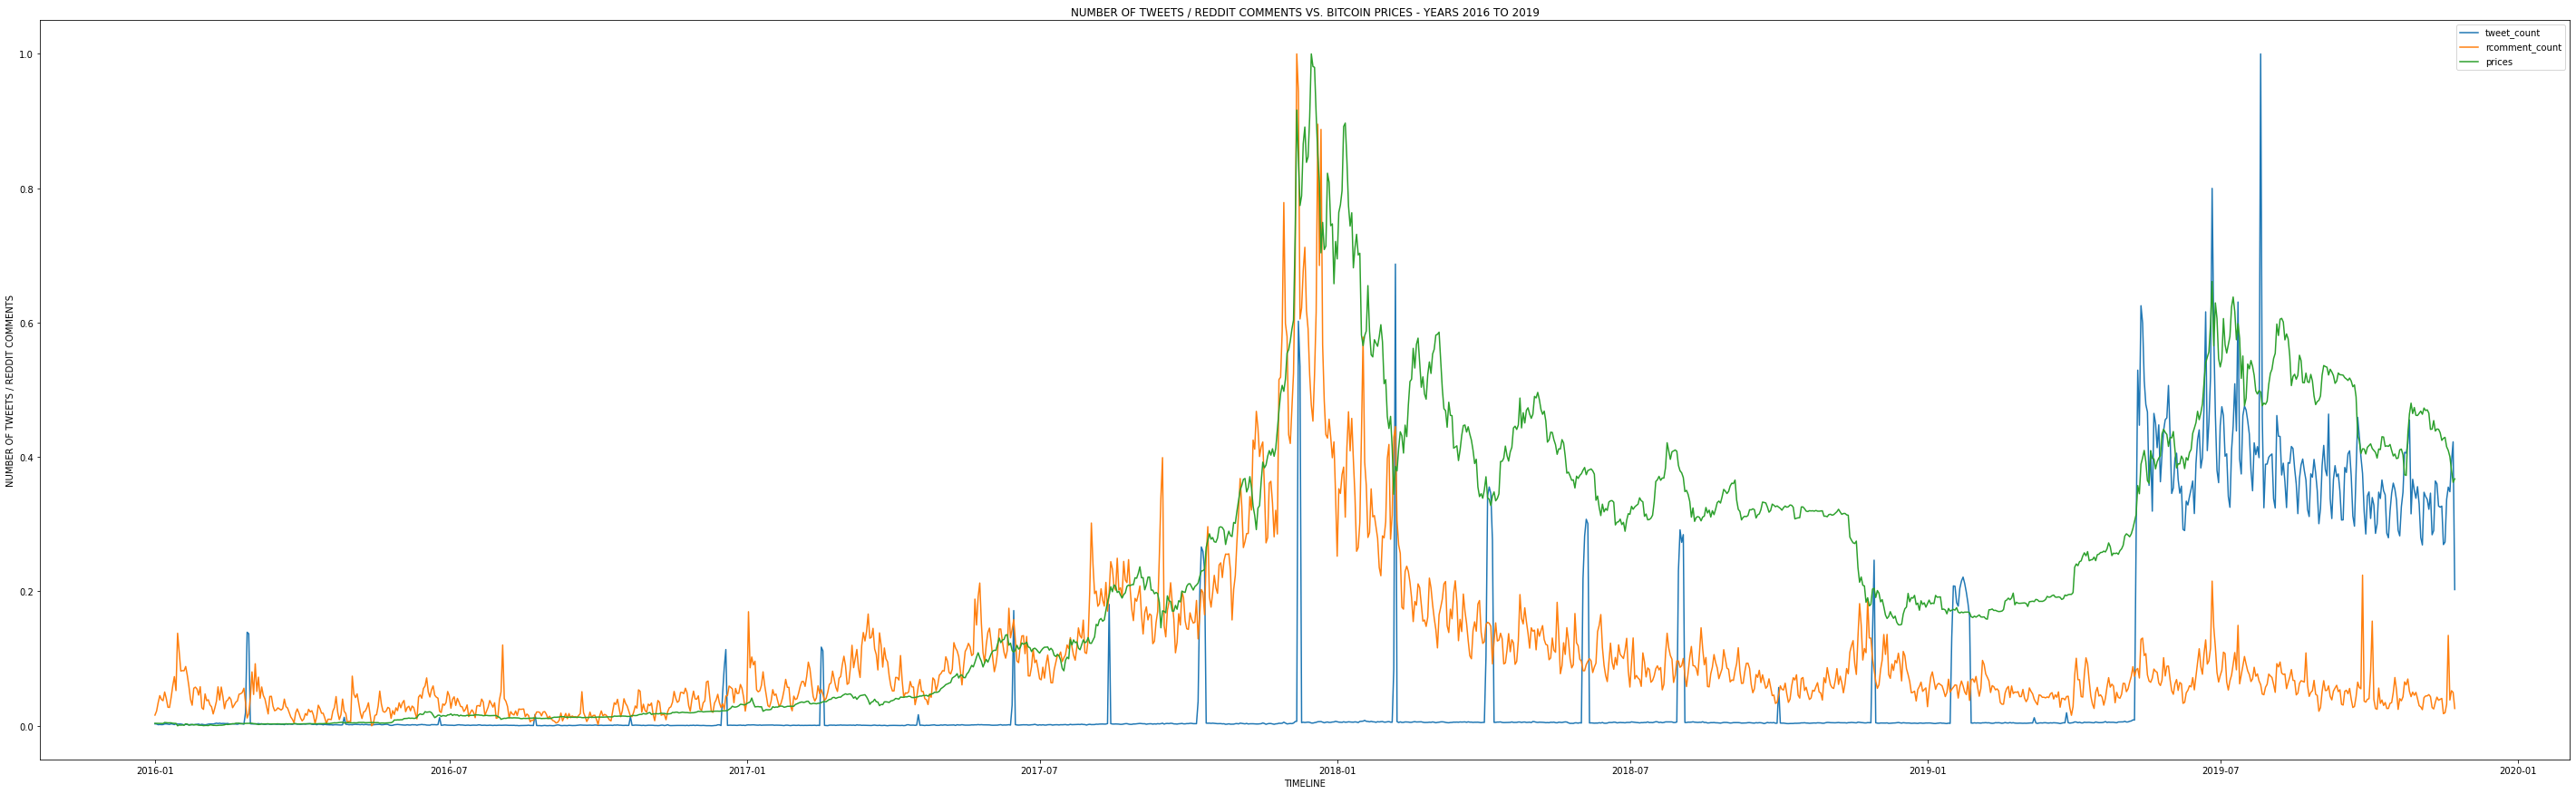

In [12]:
# Using Line Plot 
q1_scaled.plot(x = "Date", y = ["tweet_count", "rcomment_count", "prices"], \
              ylabel = "NUMBER OF TWEETS / REDDIT COMMENTS", figsize=(50,15), xlabel = "TIMELINE", \
              title = "NUMBER OF TWEETS / REDDIT COMMENTS VS. BITCOIN PRICES - YEARS 2016 TO 2019")

## Computational Task 2
### What are the most common words that are used in tweets and comments, that could have a positive and negative impact?

In [13]:
# Download Stop Words
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/akshatp/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [14]:
# Combining Stop Words
stop_words = list(get_stop_words('en'))         # About 900 stopwords
nltk_words = list(stopwords.words('english'))  # About 150 stopwords
stop_words.extend(nltk_words)
btc_words =  ["bitcoin", "", "btc", "crypto", "cryptocurrency", "twitter", "amp", "best", "new", "still", \
              "people", "alert", "see", "thanks", "next", "make", "lot", "see", "last", "free", "great", "going", "today", \
             "join", "let", "going", "also", "always", "huge", "via", "better", "check", "much", "awesome", "check", \
              "coming", "right", "future", "hopefully", "blockchain", "price", "think", "found", "1", "5", "000", \
              "payment", "2021", "10", "news", "money", "accepting", "ready", "well", "02", "08", "plans", "start", \
              "2", "5b", "current", "day", "around", "0", "follow","43", "seller", "accept","us","20","first", \
              "cryptocurrencies","every","ath","12","everything","currency","link","week", "btcusd", "bitcoinnews", \
              "chart", "another","battery","know","01","3","days", "go", "15", "way","sec", "ada", "giftideas","bark", \
              "21","usd","shopping","everyone","team","need","keep", "year", "bsc","pufferswap","soon","nice","bark", \
              "44","take", "coin","bit stamp", "cash", "chrome", "uses", "fx", "browser", "7", "real", "defi", "ever", \
              "finance", "fud", "xrp", "top", "really", "years", "hodl", "many","markets","bnb", "time", "shop", "gift", \
             "even", "daily"]
stop_words.extend(btc_words)

In [15]:
# Creating table for stopwords
words_stop = spark.createDataFrame(stop_words, StringType())
words_stop.registerTempTable("words_stop")

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


### TOP 10 Positive

In [16]:
prices_top10 = sqlContext.sql("SELECT date, ((Close-Open)/Open*100) as per_change FROM prices \
              WHERE date BETWEEN '2021-01-01' AND '2022-09-30' ORDER BY per_change DESC LIMIT 10")
prices_top10.registerTempTable("prices_top10")

In [17]:
clean_text_top10 = sqlContext.sql("SELECT DISTINCT b.date, a.clean_text from tweets2021 a JOIN prices_top10 b \
                 ON a.date = b.date WHERE a.clean_text IS NOT NULL ")
clean_text_top10.registerTempTable("clean_text_top10")

In [18]:
word_count_top10 = clean_text_top10.withColumn('word', f.explode(f.split(f.col('clean_text'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)
word_count_top10.registerTempTable("word_count_top10")

In [19]:
# Final table for word count after removing stop words
final_cloud_top10 = sqlContext.sql("SELECT word, count FROM word_count_top10 WHERE word NOT IN (SELECT value from words_stop) \
                  ORDER BY count DESC LIMIT 100")
final_cloud_top10.registerTempTable("final_cloud_top10")

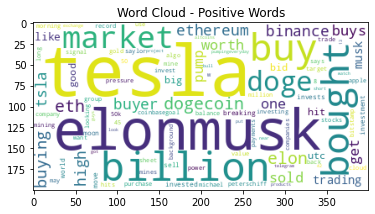

In [20]:
# Creating Word cloud
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*final_cloud_top10.select(f.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
plt.imshow(wordcloud.generate_from_frequencies(words))
plt.title("Word Cloud - Positive Words")
plt.show()

### Bottom 10 Analysis

In [21]:
prices_bottom10 = sqlContext.sql("SELECT date, ((Close-Open)/Open*100) as per_change FROM prices \
              WHERE date BETWEEN '2021-01-01' AND '2022-09-30' ORDER BY per_change ASC LIMIT 10")
prices_bottom10.registerTempTable("prices_bottom10")

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [22]:
clean_text_bottom10 = sqlContext.sql("SELECT DISTINCT b.date, a.clean_text from tweets2021 a JOIN prices_bottom10 b \
                 ON a.date = b.date WHERE a.clean_text IS NOT NULL ")
clean_text_bottom10.registerTempTable("clean_text_bottom10")

In [23]:
word_count_bottom10 = clean_text_bottom10.withColumn('word', f.explode(f.split(f.col('clean_text'), ' ')))\
    .groupBy('word')\
    .count()\
    .sort('count', ascending=False)
word_count_bottom10.registerTempTable("word_count_bottom10")

In [24]:
# Final table for word count after removing stop words
final_cloud_bottom10 = sqlContext.sql("SELECT word, count FROM word_count_bottom10 WHERE word NOT IN (SELECT value from words_stop) \
                  ORDER BY count DESC LIMIT 100")
final_cloud_bottom10.registerTempTable("final_cloud_bottom10")

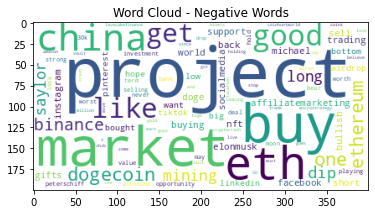

In [25]:
# Creating Word cloud
wordcloud = WordCloud(background_color="white")

words = dict(ChainMap(*final_cloud_bottom10.select(f.create_map('word', 'count')).rdd.map(lambda x: x[0]).collect()))
plt.imshow(wordcloud.generate_from_frequencies(words))
plt.title("Word Cloud - Negative Words")
plt.show()

## Computational Task 3
### How do people with verified twitter accounts and more followers react to changes in the prices?

In [26]:
# Verified accounts
vtweet_count = sqlContext.sql("SELECT date, COUNT(user_name) as vuser_count FROM tweets2021 \
           WHERE user_verified == TRUE AND date IS NOT NULL AND date BETWEEN '2021-01-01' AND '2022-09-30'\
           GROUP BY date ORDER BY DATE")
vtweet_count.registerTempTable("vtweet_count")

/sw/pkgs/arc/spark/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [27]:
prices_scaled = sqlContext.sql("SELECT a.date, a.vuser_count, b.Close FROM vtweet_count a JOIN \
        (SELECT date, Close FROM prices WHERE Date BETWEEN '2021-01-01' AND '2022-09-30') b \
        ON a.date = b.Date ORDER BY a.date ASC")
prices_scaled.registerTempTable("prices_scaled")

In [28]:
prices_scaledpd = prices_scaled.toPandas()
q3_scaled = prices_scaledpd.copy()
q3_scaled[['vuser_count']] = scaler.fit_transform(q3_scaled[['vuser_count']])
q3_scaled[['Close']] = scaler.fit_transform(q3_scaled[['Close']])

<AxesSubplot: title={'center': 'NUMBER OF TWEETS BY VERIFIED USERS WITH PRICE FLUCTUATION - YEARS 2021 & 2022'}, xlabel='TIMELINE', ylabel='NUMBER OF TWEETS BY VERIFIED USERS'>

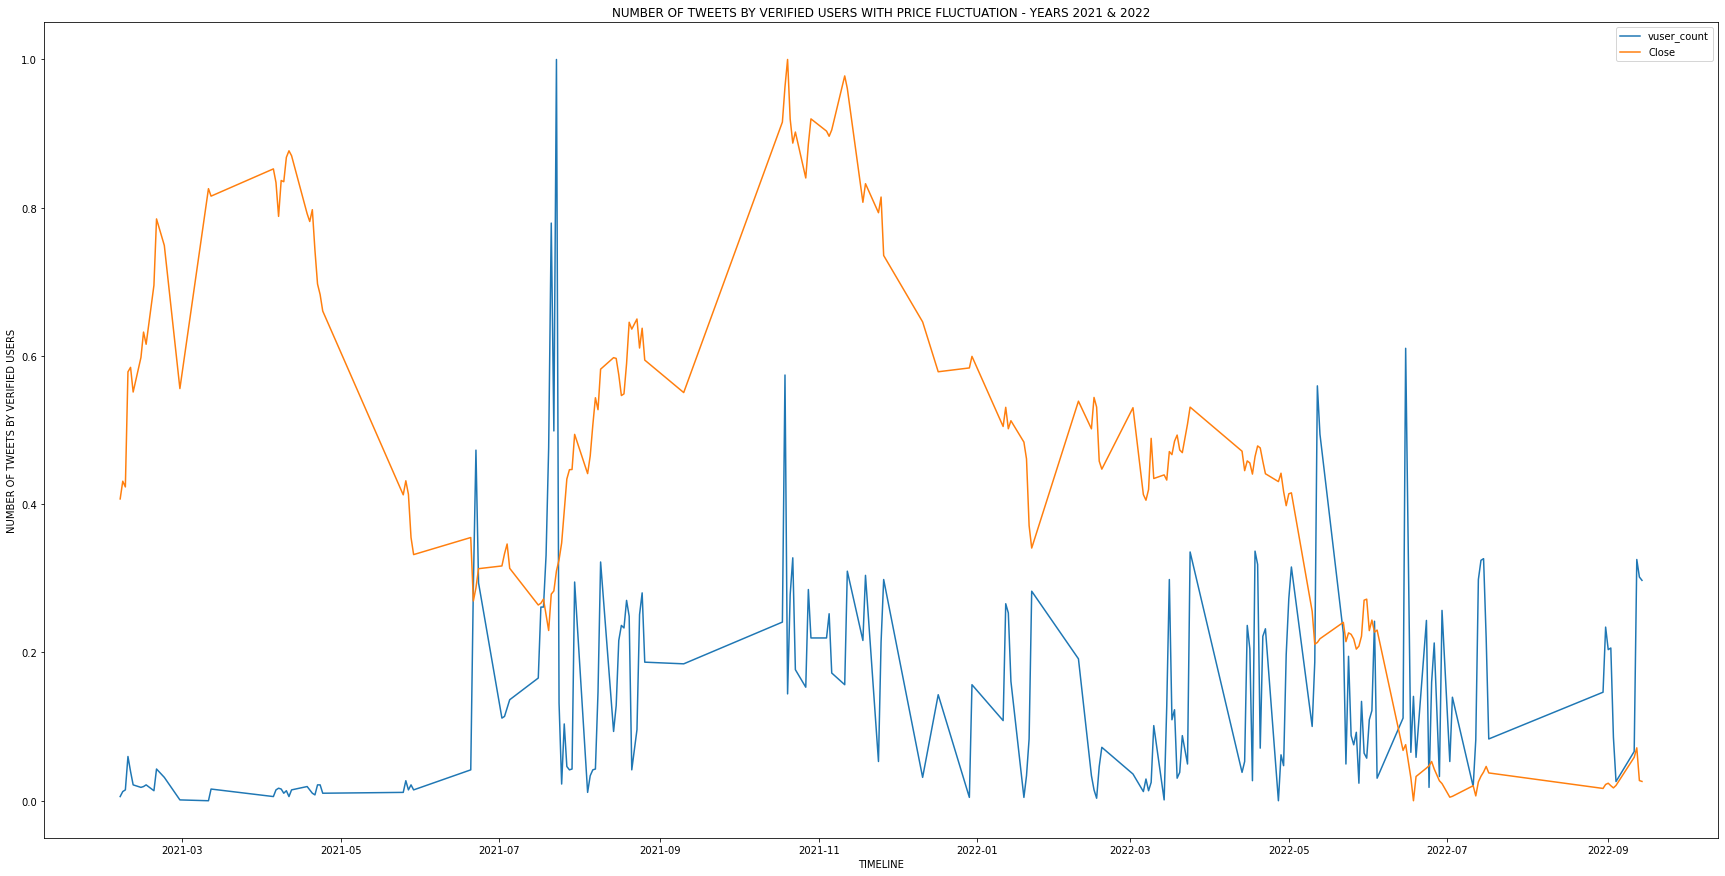

In [32]:
q3_scaled.plot.line(x = "date", y = ["vuser_count", "Close"], \
              ylabel = "NUMBER OF TWEETS BY VERIFIED USERS", figsize=(30,15), xlabel = "TIMELINE", \
              title = "NUMBER OF TWEETS BY VERIFIED USERS WITH PRICE FLUCTUATION - YEARS 2021 & 2022")

<AxesSubplot: title={'center': 'NUMBER OF TWEETS BY VERIFIED USERS - YEARS 2021 & 2022'}, xlabel='date'>

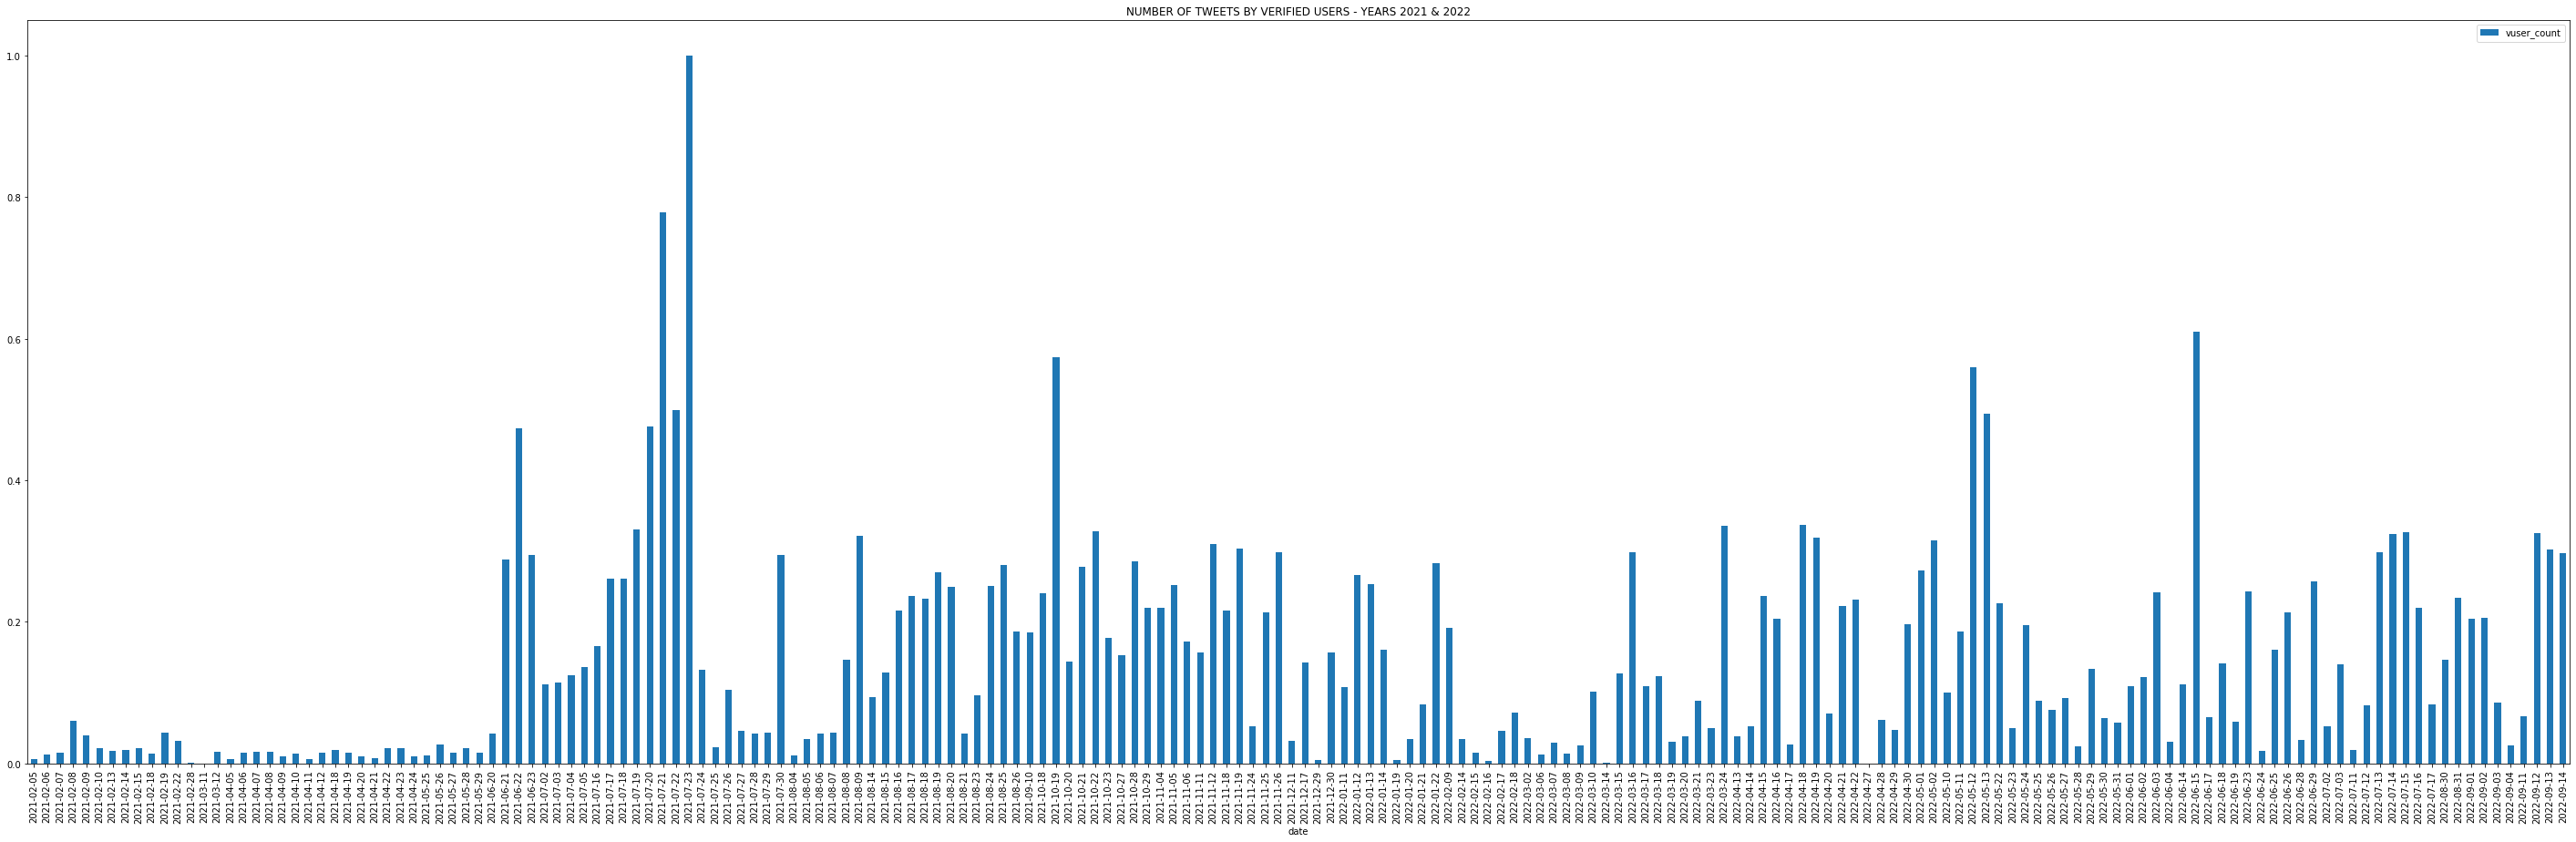

In [30]:
q3_scaled.plot.bar(x = 'date', y = 'vuser_count', figsize = (50,15), \
                   title = "NUMBER OF TWEETS BY VERIFIED USERS - YEARS 2021 & 2022")